In [15]:
import gymnasium as gym
import math
import random
import matplotlib.pyplot as plt
from collections import deque
import os

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [16]:
env = gym.make("CartPole-v1", render_mode="rgb_array") 
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
 )

device

device(type='mps')

In [17]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return (torch.FloatTensor(np.float32(state)), 
                torch.LongTensor(action), 
                torch.FloatTensor(reward), 
                torch.FloatTensor(np.float32(next_state)),
                torch.BoolTensor(done))

    def __len__(self):
        return len(self.buffer)

class DQNAgent:
    def __init__(self, state_dim, n_actions, device="cpu"):
        self.device = device
        self.n_actions = n_actions
        self.state_dim = state_dim

        self.policy_net = DQN(state_dim, n_actions).to(device)
        self.target_net = DQN(state_dim, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.batch_size = 128
        self.gamma = 0.99
        self.eps_start = 1.0
        self.eps_end = 0.01
        self.eps_decay = 5000
        self.target_update = 1000
        self.steps_done = 0
        self.lr = 1e-4

        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=self.lr, amsgrad=True)
        self.memory = ReplayBuffer(10000)

    def select_action(self, state):
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * math.exp(-1. * self.steps_done / self.eps_decay)
        self.steps_done += 1

        if random.random() > eps_threshold:
            with torch.no_grad():
                state_tensor = torch.as_tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
                q_values = self.policy_net(state_tensor)
                return q_values.max(1)[1].item()
        else:
            return random.randrange(self.n_actions)

    def select_greedy_action(self, state):
        with torch.no_grad():
            state_tensor = torch.as_tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            q_values = self.policy_net(state_tensor)
            return q_values.max(1)[1].item()

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return None

        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.memory.sample(self.batch_size)

        state_batch = state_batch.to(self.device)
        action_batch = action_batch.to(self.device)
        reward_batch = reward_batch.to(self.device)
        next_state_batch = next_state_batch.to(self.device)
        done_batch = done_batch.to(self.device)

        current_q_values = self.policy_net(state_batch).gather(1, action_batch.unsqueeze(1))

        with torch.no_grad():
            next_state_values = self.target_net(next_state_batch).max(1)[0]
            next_state_values = next_state_values.masked_fill(done_batch, 0.0)
            expected_q_values = reward_batch + self.gamma * next_state_values

        loss = nn.SmoothL1Loss()(current_q_values.squeeze(), expected_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 100)
        self.optimizer.step()

        return loss.item()

In [18]:
def play_game(agent, env, episodes=1):
    rewards = []
    for _ in range(episodes):
        state, _ = env.reset()
        total_reward = 0.0
        done = False
        truncated = False

        while not (done or truncated):
            action = agent.select_greedy_action(state)
            state, reward, done, truncated, _ = env.step(action)
            total_reward += reward

        rewards.append(total_reward)
    return rewards

In [19]:
def train(agent, env, num_episodes=1000):
    os.makedirs("./model_weights/DQN/cartpole", exist_ok=True)
    rewards = []
    curr_policy_rewards = []
    for episode in range(num_episodes):

        env.reset()
        curr_policy_rewards.append(play_game(agent, env, episodes=1)[0])
        
        state, _ = env.reset()
        total_reward = 0.0
        done = False
        truncated = False

        while not (done or truncated):
            action = agent.select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            agent.memory.push(state, action, reward, next_state, done or truncated)

            agent.optimize_model()
            state = next_state
            total_reward += reward

            if agent.steps_done % agent.target_update == 0:
                agent.target_net.load_state_dict(agent.policy_net.state_dict())

        print(f"Episode {episode}, Total Reward: {curr_policy_rewards[-1]}, Steps: {agent.steps_done}")
        rewards.append(total_reward)

        if episode % 100 == 99:
            torch.save(agent.policy_net.state_dict(), f"./model_weights/DQN/cartpole/cartpole_dqn_episode_{episode}.pth")

    torch.save(agent.policy_net.state_dict(), "./model_weights/DQN/cartpole/cartpole_dqn_episode_end.pth")
    return agent, rewards, curr_policy_rewards

In [20]:
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

agent = DQNAgent(state_dim, n_actions, device)

In [21]:
weights_dir = "./model_weights/DQN/cartpole"
eps_policy_rewards_path = os.path.join(weights_dir, "curr_policy_rewards.npy")
eval_policy_rewards_path =os.path.join(weights_dir, "eval_policy_rewards.npy") 
final_weights_path = os.path.join(weights_dir, "cartpole_dqn_episode_end.pth")
os.makedirs(weights_dir, exist_ok=True)

num_episodes = 4000

if os.path.exists(final_weights_path) and os.path.exists(eps_policy_rewards_path):
    agent.policy_net.load_state_dict(torch.load(final_weights_path, map_location=device))
    agent.target_net.load_state_dict(agent.policy_net.state_dict())
    curr_policy_rewards = np.load(eps_policy_rewards_path)
    eval_rewards = np.load(eval_policy_rewards_path)
else:
    agent, curr_policy_rewards, eval_rewards = train(agent, env, num_episodes=num_episodes)
    np.save(eps_policy_rewards_path, np.array(curr_policy_rewards))
    np.save(eval_policy_rewards_path, np.array(eval_rewards))

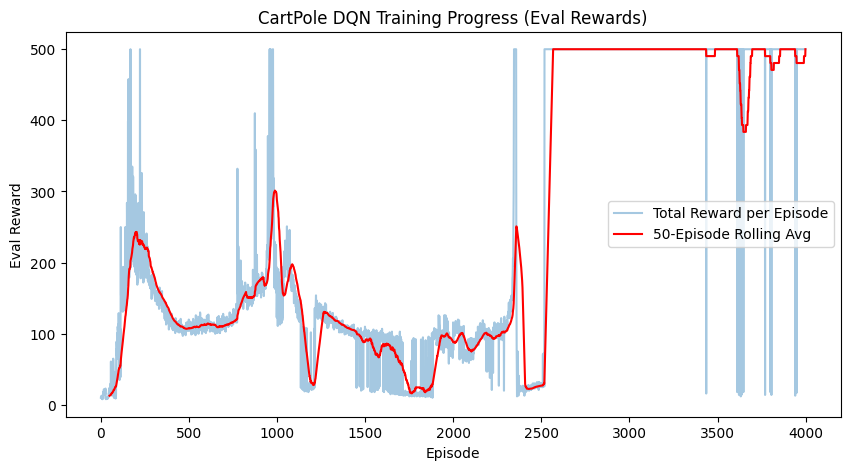

In [26]:
window = 50
plt.figure(figsize=(10, 5))
plt.plot(eval_rewards, label="Total Reward per Episode", alpha=0.4)

if len(eval_rewards) >= window:
    rolling_avg = np.convolve(_, np.ones(window) / window, mode='valid')
    rolling_x = np.arange(window - 1, len(eval_rewards))
    plt.plot(rolling_x, rolling_avg, label=f"{window}-Episode Rolling Avg", color="red")

plt.xlabel("Episode")
plt.ylabel("Eval Reward")
plt.title("CartPole DQN Training Progress (Eval Rewards)")
plt.legend()
os.makedirs("./images/DQN", exist_ok=True)
plt.savefig("./images/DQN/DQN_cartpole_eval_reward.pdf", bbox_inches="tight", format="pdf")
plt.show()

In [23]:
def display_game(agent):
    from IPython import display
    plt.ion()

    state, _ = env.reset()
    total_reward = 0.0
    done = False
    truncated = False

    while not (done or truncated):
        frame = env.render()
        plt.figure(figsize=(6, 6))
        plt.imshow(frame)
        plt.axis('off')
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.close()

        action = agent.select_greedy_action(state)
        state, reward, done, truncated, _ = env.step(action)
        total_reward += reward
        print(f"Total Reward: {total_reward}")

    plt.ioff()

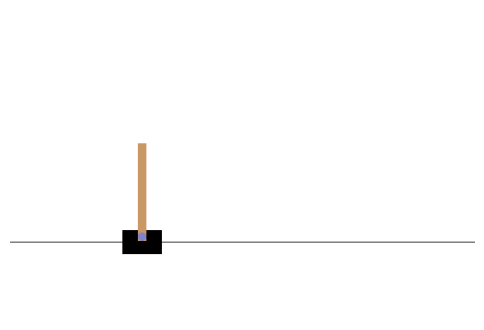

Total Reward: 500.0


In [24]:
display_game(agent)